In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
board_dict = {
    "a" : 1, "b" : 2, "c" : 3, "d" : 4, 
    "e" : 5, "f" : 6, "g" : 7, "h" : 8
}
depth_dict = {
    "zero" : 0, "one" : 1, "two" : 2, "three" : 3,
    "four" : 4, "five" : 5, "six" : 6, "seven" : 7,
    "eight" : 8, "nine" : 9, "ten" : 10, "eleven" : 11,
    "twelve" : 12, "thirteen" : 13, "fourteen" : 14, "fifteen" : 15,
    "sixteen" : 16, "draw" : 17
}
# f = lambda x: np.array([board_dict.get(x[0]), x[1], board_dict.get(x[2]), x[3], board_dict.get(x[4]), x[5], depth_dict.get(x[6])])

In [3]:
# data = np.loadtxt('train.data', delimiter=',', dtype='str')
# data = np.array([f(row) for row in data], dtype=np.float32)

data = pd.read_csv('train.data', names=['wking_file', 'wking_rank', 'wrook_file', 'wrook_rank', 'bking_file', 'bking_rank', 'depth'])

data['wking_file'] = data['wking_file'].apply(lambda x : board_dict.get(x))
data['wrook_file'] = data['wrook_file'].apply(lambda x : board_dict.get(x))
data['bking_file'] = data['bking_file'].apply(lambda x : board_dict.get(x))
data['depth'] = data['depth'].apply(lambda x : depth_dict.get(x))

data.head()

wking_file  wking_rank  wrook_file  wrook_rank  bking_file  bking_rank  \
0           4           1           4           5           6           5   
1           3           2           7           7           5           8   
2           2           1           6           7           8           7   
3           3           2           4           1           7           5   
4           4           1           4           7           7           2   

   depth  
0     14  
1     10  
2     13  
3     13  
4     12

<AxesSubplot:xlabel='depth', ylabel='count'>

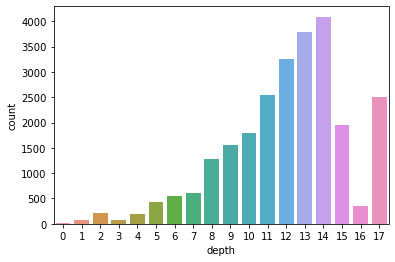

In [4]:
sns.countplot(x = 'depth', data=data)

In [5]:
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=1)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0,
        "5": 0,
        "6": 0,
        "7": 0,
        "8": 0,
        "9": 0,
        "10": 0,
        "11": 0,
        "12": 0,
        "13": 0,
        "14": 0,
        "15": 0,
        "16": 0,
        "draw": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0'] += 1
        elif i == 1: 
            count_dict['1'] += 1
        elif i == 2: 
            count_dict['2'] += 1
        elif i == 3: 
            count_dict['3'] += 1
        elif i == 4: 
            count_dict['4'] += 1  
        elif i == 5: 
            count_dict['5'] += 1
        elif i == 6: 
            count_dict['6'] += 1
        elif i == 7: 
            count_dict['7'] += 1
        elif i == 8: 
            count_dict['8'] += 1 
        elif i == 9: 
            count_dict['9'] += 1
        elif i == 10: 
            count_dict['10'] += 1
        elif i == 11: 
            count_dict['11'] += 1
        elif i == 12: 
            count_dict['12'] += 1 
        elif i == 13: 
            count_dict['13'] += 1 
        elif i == 14: 
            count_dict['14'] += 1
        elif i == 15: 
            count_dict['15'] += 1
        elif i == 16: 
            count_dict['16'] += 1
        elif i == 17: 
            count_dict['draw'] += 1              
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

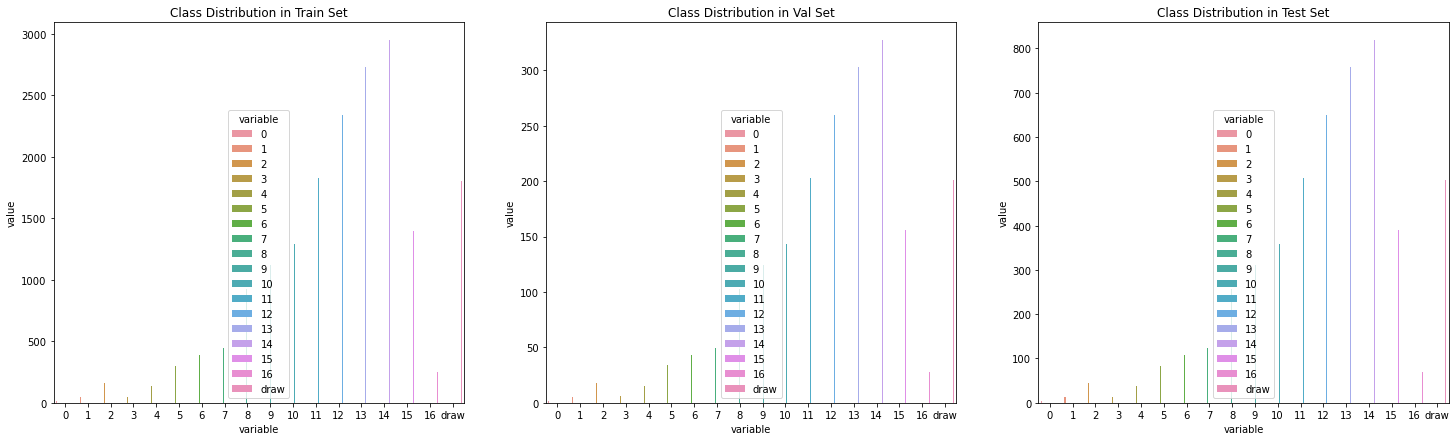

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [10]:
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X) 

In [11]:
train_dataset = ChessDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ChessDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ChessDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0556, 0.0204, 0.0063, 0.0200, 0.0075, 0.0033, 0.0026, 0.0022, 0.0011,
        0.0009, 0.0008, 0.0005, 0.0004, 0.0004, 0.0003, 0.0007, 0.0039, 0.0006])


In [14]:
class_weights_all = class_weights[target_list]

In [15]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [24]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 18

In [25]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [47]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [60]:
model = torch.load(r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt')

In [61]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=6, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [62]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [63]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [64]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

     # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
        

Begin training.


Epoch 001: | Train Loss: 1.25124 | Val Loss: 2.91083 | Train Acc: 23.332| Val Acc: 5.594
Epoch 002: | Train Loss: 0.98693 | Val Loss: 2.60450 | Train Acc: 29.141| Val Acc: 12.574
Epoch 003: | Train Loss: 0.89840 | Val Loss: 2.54002 | Train Acc: 32.063| Val Acc: 13.812
Epoch 004: | Train Loss: 0.89031 | Val Loss: 2.48375 | Train Acc: 33.466| Val Acc: 16.386
Epoch 005: | Train Loss: 0.84820 | Val Loss: 2.37486 | Train Acc: 34.831| Val Acc: 17.030
Epoch 006: | Train Loss: 0.85033 | Val Loss: 2.24333 | Train Acc: 35.245| Val Acc: 20.644
Epoch 007: | Train Loss: 0.81481 | Val Loss: 2.38629 | Train Acc: 37.094| Val Acc: 14.950
Epoch 008: | Train Loss: 0.82530 | Val Loss: 2.31068 | Train Acc: 36.134| Val Acc: 17.921
Epoch 009: | Train Loss: 0.78305 | Val Loss: 2.20754 | Train Acc: 37.257| Val Acc: 20.099
Epoch 010: | Train Loss: 0.74527 | Val Loss: 2.26119 | Train Acc: 37.566| Val Acc: 21.238
Epoch 011: | Train Loss: 0.72076 | Val Loss: 2.15504 | Train Acc: 38.080| Val Acc: 20.050
Epoch 012: 

Epoch 093: | Train Loss: 0.55735 | Val Loss: 1.96498 | Train Acc: 45.275| Val Acc: 24.901
Epoch 094: | Train Loss: 0.53525 | Val Loss: 2.04892 | Train Acc: 44.851| Val Acc: 24.802
Epoch 095: | Train Loss: 0.53186 | Val Loss: 1.98347 | Train Acc: 45.373| Val Acc: 25.347
Epoch 096: | Train Loss: 0.52829 | Val Loss: 2.10918 | Train Acc: 45.314| Val Acc: 24.703
Epoch 097: | Train Loss: 0.53029 | Val Loss: 2.01939 | Train Acc: 45.284| Val Acc: 24.752
Epoch 098: | Train Loss: 0.53517 | Val Loss: 1.95240 | Train Acc: 44.995| Val Acc: 27.079
Epoch 099: | Train Loss: 0.53142 | Val Loss: 2.04734 | Train Acc: 45.692| Val Acc: 27.030
Epoch 100: | Train Loss: 0.54223 | Val Loss: 2.12861 | Train Acc: 45.367| Val Acc: 25.990
Epoch 101: | Train Loss: 0.52968 | Val Loss: 2.05216 | Train Acc: 45.542| Val Acc: 24.455
Epoch 102: | Train Loss: 0.51282 | Val Loss: 2.00965 | Train Acc: 45.985| Val Acc: 26.139
Epoch 103: | Train Loss: 0.52150 | Val Loss: 1.95360 | Train Acc: 44.805| Val Acc: 27.426
Epoch 104:

Epoch 185: | Train Loss: 0.47772 | Val Loss: 2.13413 | Train Acc: 47.103| Val Acc: 23.218
Epoch 186: | Train Loss: 0.47208 | Val Loss: 2.01062 | Train Acc: 47.049| Val Acc: 26.287
Epoch 187: | Train Loss: 0.46406 | Val Loss: 2.08953 | Train Acc: 47.264| Val Acc: 26.535
Epoch 188: | Train Loss: 0.49286 | Val Loss: 2.04304 | Train Acc: 46.847| Val Acc: 23.911
Epoch 189: | Train Loss: 0.47160 | Val Loss: 1.98916 | Train Acc: 47.717| Val Acc: 25.891
Epoch 190: | Train Loss: 0.47858 | Val Loss: 1.98253 | Train Acc: 47.164| Val Acc: 25.792
Epoch 191: | Train Loss: 0.45651 | Val Loss: 2.11635 | Train Acc: 47.067| Val Acc: 25.941
Epoch 192: | Train Loss: 0.46028 | Val Loss: 2.06625 | Train Acc: 47.718| Val Acc: 26.089
Epoch 193: | Train Loss: 0.48737 | Val Loss: 2.04830 | Train Acc: 47.129| Val Acc: 26.436
Epoch 194: | Train Loss: 0.46796 | Val Loss: 2.01209 | Train Acc: 47.913| Val Acc: 28.267
Epoch 195: | Train Loss: 0.46153 | Val Loss: 1.96427 | Train Acc: 47.519| Val Acc: 27.525
Epoch 196:

Epoch 277: | Train Loss: 0.46457 | Val Loss: 2.11306 | Train Acc: 48.633| Val Acc: 21.337
Epoch 278: | Train Loss: 0.45436 | Val Loss: 2.00484 | Train Acc: 48.674| Val Acc: 25.396
Epoch 279: | Train Loss: 0.45067 | Val Loss: 2.06345 | Train Acc: 48.949| Val Acc: 25.743
Epoch 280: | Train Loss: 0.45722 | Val Loss: 2.11972 | Train Acc: 48.476| Val Acc: 21.584
Epoch 281: | Train Loss: 0.44018 | Val Loss: 2.05013 | Train Acc: 49.222| Val Acc: 24.901
Epoch 282: | Train Loss: 0.44896 | Val Loss: 1.98010 | Train Acc: 48.676| Val Acc: 27.921
Epoch 283: | Train Loss: 0.44868 | Val Loss: 2.04976 | Train Acc: 48.642| Val Acc: 25.990
Epoch 284: | Train Loss: 0.42717 | Val Loss: 1.93819 | Train Acc: 48.848| Val Acc: 28.713
Epoch 285: | Train Loss: 0.46655 | Val Loss: 1.89332 | Train Acc: 47.717| Val Acc: 28.564
Epoch 286: | Train Loss: 0.42522 | Val Loss: 1.97352 | Train Acc: 49.260| Val Acc: 28.465
Epoch 287: | Train Loss: 0.45926 | Val Loss: 1.92798 | Train Acc: 48.850| Val Acc: 30.297
Epoch 288:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

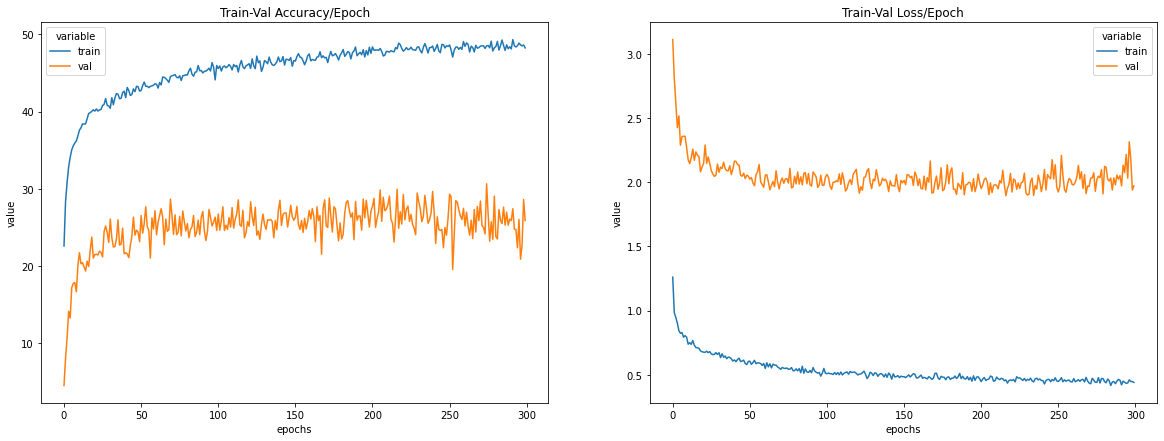

In [32]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [65]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

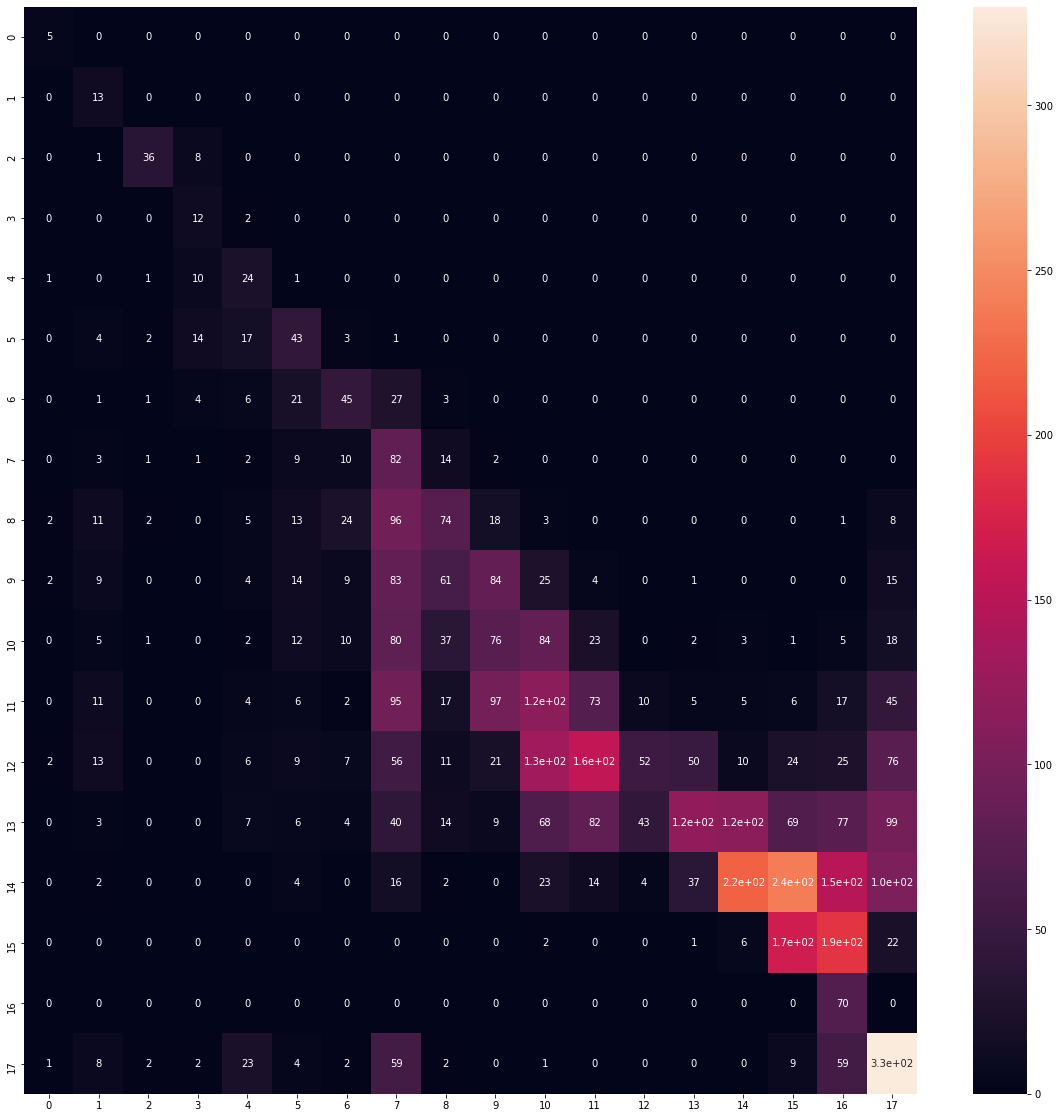

In [66]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

plt.figure(figsize = (20, 20))
sns.heatmap(confusion_matrix_df, annot=True)

In [67]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.38      1.00      0.56         5
           1       0.15      1.00      0.27        13
           2       0.78      0.80      0.79        45
           3       0.24      0.86      0.37        14
           4       0.24      0.65      0.35        37
           5       0.30      0.51      0.38        84
           6       0.39      0.42      0.40       108
           7       0.13      0.66      0.22       124
           8       0.31      0.29      0.30       257
           9       0.27      0.27      0.27       311
          10       0.19      0.23      0.21       359
          11       0.21      0.14      0.17       508
          12       0.48      0.08      0.14       650
          13       0.56      0.16      0.25       757
          14       0.61      0.27      0.37       818
          15       0.32      0.43      0.37       389
          16       0.12      1.00      0.21        70
          17       0.46    

In [68]:
torch.save(model.state_dict(), r'C:\Users\diasa\Machine-Learning\King-Rook_vs_King\model_scripted.pt')